# Comparison of *revrand*'s algorithms on the SARCOS dataset

In this notebook we test how the GLM in *revrand* performs on the inverse dynamics experiment conducted in Gaussian Processes for Machine Learning, Chapter 8, page 182. In this experiment there are 21 dimensions, and 44,484 training examples. All GP's are using square exponential covariance functions, with a seperate lengthscale for each dimension.

In [8]:
import logging
import numpy as np
from scipy.stats import gamma 

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

from revrand import GeneralizedLinearModel, Parameter, Positive
from revrand.basis_functions import RandomRBF
from revrand.likelihoods import Gaussian
from revrand.metrics import smse, msll
from revrand.utils.datasets import fetch_gpml_sarcos_data
from revrand.optimize import Adam, AdaDelta

from plotting import fancy_yyplot
import matplotlib.pyplot as pl
%matplotlib inline

logging.basicConfig(level=logging.INFO)

### Settings

In [9]:
lenscale = gamma(2, scale=50)
regularizer = gamma(2, scale=10)
var = gamma(2, scale=50)
nbases = 256
random_state = 100
nsamples = 10

batch_size = 10
maxiter = int(1e6)
updater = Adam()

doGP = False
m = 1024
n_restarts=1

### Load the data

In [10]:
gpml_sarcos = fetch_gpml_sarcos_data()

X_train = gpml_sarcos.train.data
y_train = gpml_sarcos.train.targets

X_test = gpml_sarcos.test.data
y_test = gpml_sarcos.test.targets

Ntrain, D = X_train.shape

print("Training data shape = {}".format(X_train.shape))
print("Testing data shape = {}".format(X_test.shape))


Training data shape = (44484, 21)
Testing data shape = (4449, 21)


### Transform targets and inputs
As per GPML p23

In [11]:
# Targets
ymean = y_train.mean()
y_train -= ymean
y_test -= ymean

# Inputs
Xscaler = StandardScaler()
Xscaler.fit(X_train)
X_train = Xscaler.transform(X_train)
X_test = Xscaler.transform(X_test)

### Initialise the algorithms

In [12]:
if not doGP:
    lenscale_init = Parameter(lenscale, Positive(), shape=(D,))
    var_init = Parameter(var, Positive())
    regularizer_init = Parameter(regularizer, Positive())

    base = RandomRBF(nbases=nbases,
                     Xdim=D,
                     lenscale=lenscale_init,
                     random_state=random_state,
                     regularizer=regularizer_init
                    )
    llhood = Gaussian(var=var_init)

    alg = GeneralizedLinearModel(llhood,
                                 base,
                                 updater=updater,
                                 batch_size=batch_size,
                                 maxiter=maxiter,
                                 nsamples=nsamples,
                                 random_state=random_state
                                )
else:
    kern = 3**2 * RBF(length_scale=np.ones(D), length_scale_bounds=(1e-3, 1e7)) \
        + WhiteKernel(noise_level=1)
    alg = GaussianProcessRegressor(kernel=kern, n_restarts_optimizer=n_restarts)

### Train the algorithms

In [13]:
if not doGP:
    alg.fit(X_train, y_train)
else:
    rnd = np.random.RandomState(random_state)
    t_ind = rnd.choice(Ntrain, size=m, replace=False)
    alg.fit(X_train[t_ind], y_train[t_ind])


INFO:revrand.glm:Optimising parameters...
INFO:revrand.optimize.decorators:Evaluating random starts...
INFO:revrand.glm:Random starts: Iter -500: ELBO = -289585.1908463775, reg = 9.980620460674071, like_hypers = 170.06777231286802, basis_hypers = [  14.19876928   74.6792396   176.21044633  351.62225112   70.15981801
  307.40350798   62.14054287  248.87801898   42.28770451   79.81240218
  129.58761983  197.11652637   23.09789818   82.93217478   71.79684822
   51.71420735  124.15671645   29.04110943  128.59201912  112.15952212
  113.83099516]
INFO:revrand.optimize.decorators:Best start found with objective = 152622.79764083883
INFO:revrand.glm:Iter 0: ELBO = -301929.7264538195, reg = 7.088966359978286, like_hypers = 84.42554056146852, basis_hypers = [  90.29575854  230.81568867   30.03376273   77.09585798  193.12896031
   36.72616076  126.32955839   89.47898565   99.61560001  158.04433344
   49.27692827  172.81445062    4.77985957  114.32427778  187.71644172
   93.41180981   88.92696588 

### Predict and score



SMSE = 0.035834849927868916
MSLL = -1.664405512757271


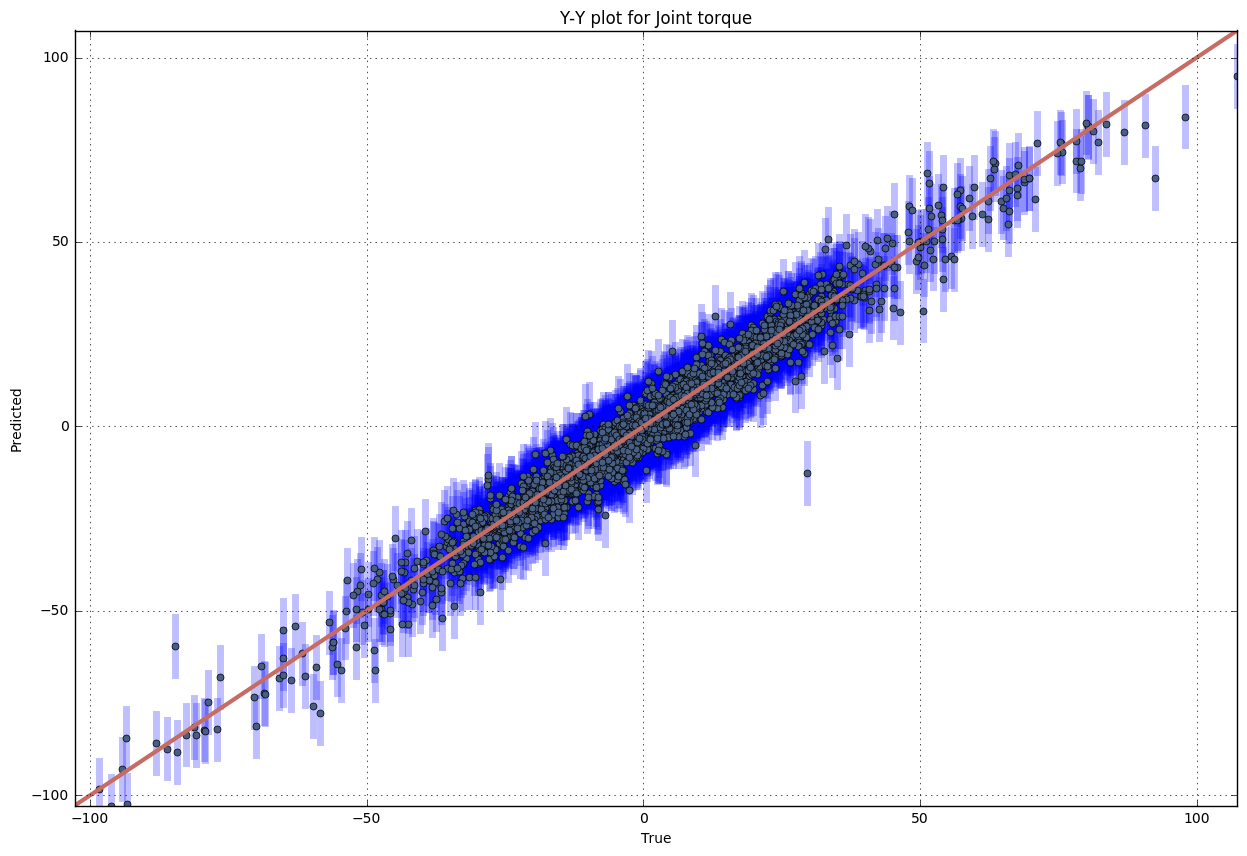

In [14]:
if not doGP:
    Ey, Vf = alg.predict_moments(X_test)
    Vy = Vf + alg.like_hypers_
    Sy = np.sqrt(Vy)
else:
    Ey, Sy = alg.predict(X_test, return_std=True)
    Vy = Sy**2

print("SMSE = {}".format(smse(y_test, Ey)))
print("MSLL = {}".format(msll(y_test, Ey, Vy, y_train)))

# YY plot
pl.figure(figsize=(15, 10))
fancy_yyplot(y_test, Ey, Ey - 2 * Sy, Ey + 2 * Sy, "Joint torque")